In [ ]:
%pip install urllib3 matplotlib

In [1]:
# Fix SSL issue with downloading dataset
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

# Loading datasets

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

In [3]:
train = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
dataset = DataLoader(train, 32)
dataset

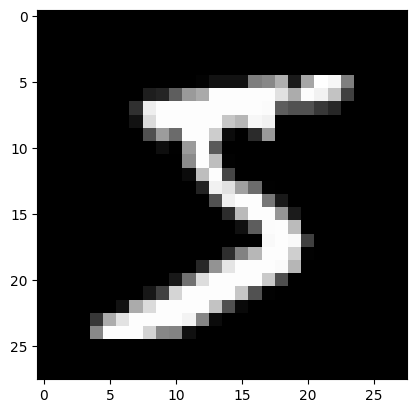

In [18]:
# Display X[0] grayscale image
image, _= next(iter(dataset))

%matplotlib inline
plt.imshow(image[0].squeeze(), cmap='gray')
plt.show()

# Create Conv2D

In [6]:
from torch import nn, save, load
from torch.optim import Adam

In [7]:
class ImageClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.Conv2d(64, 64, (3,3)), 
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(64*(28-6)*(28-6), 10)  
        )

    def forward(self, x): 
        return self.model(x)

### Instance of the neural network, loss, optimizer 

In [8]:
clf = ImageClassifier().to('mps')
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss() 

### Train

In [9]:
for epoch in range(10): # train for 10 epochs
    for batch in dataset: 
        X,y = batch 
        X, y = X.to('mps'), y.to('mps') 
        yhat = clf(X) 
        loss = loss_fn(yhat, y) 

        # Apply backprop 
        opt.zero_grad()
        loss.backward() 
        opt.step() 

    print(f"Epoch:{epoch} loss is {loss.item()}")

Epoch:0 loss is 0.041666436940431595
Epoch:1 loss is 0.0034173745661973953
Epoch:2 loss is 0.007308023050427437
Epoch:3 loss is 0.000900407088920474
Epoch:4 loss is 0.0006336268270388246
Epoch:5 loss is 0.0017072100890800357
Epoch:6 loss is 0.0001903117954498157
Epoch:7 loss is 0.00023712952679488808
Epoch:8 loss is 3.2967827792163007e-06
Epoch:9 loss is 0.0001215316224261187


In [10]:
val = datasets.MNIST(root="data", download=True, train=False, transform=ToTensor())
val_dataset = DataLoader(val, 32)

correct = 0
total = 0

for batch in val_dataset:
    X,y = batch 
    X, y = X.to('mps'), y.to('mps') 
    yhat = clf(X) 
    _, predicted = torch.max(yhat, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()

print(f"Accuracy: {correct/total}")

Accuracy: 0.9889


### Save the model

In [11]:
with open('model_state.pt', 'wb') as f: 
        save(clf.state_dict(), f) 

# Use the model to predict
### Load model

In [12]:
from PIL import Image

In [13]:
with open('model_state.pt', 'rb') as f: 
    clf.load_state_dict(load(f))  

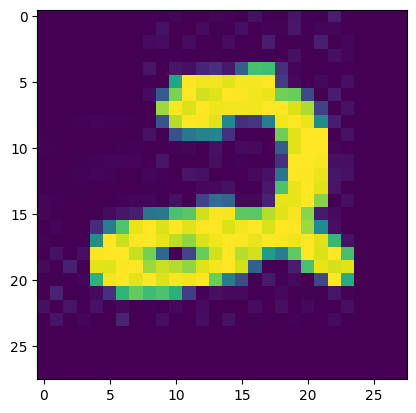

In [17]:
img = Image.open('img_1.jpg') 
img_tensor = ToTensor()(img).unsqueeze(0).to('mps')
plt.imshow(img)
plt.show()

Predicted class is 2


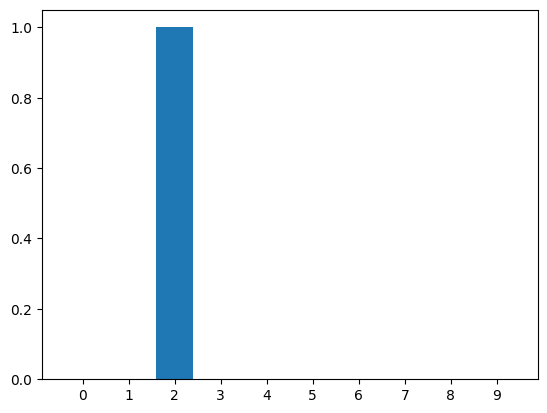

In [16]:
output = clf(img_tensor)
_, pred = torch.max(output, 1)

print(f"Predicted class is {pred.item()}")

normalized_output = torch.nn.functional.softmax(output, dim=1)
normalized_output = normalized_output.cpu().detach().numpy().flatten()

plt.bar(range(10), normalized_output, tick_label=range(10))
plt.show()